In [1]:
import os 
import torch
import random
import copy
from diffusers import FluxPipeline
from safetensors.torch import load_file
from copy import deepcopy
from diffusers.utils import make_image_grid
torch.set_grad_enabled(False)

In [2]:
def set_module(module, module_name, new_module):

    if isinstance(module_name, str):
        module_name = module_name.split('.')

    if len(module_name) == 1:
        return setattr(module, module_name[0], new_module)
    else:
        module = getattr(module, module_name[0])
        return set_module(module, module_name[1:], new_module)
    
def get_esd_trainable_parameters(esd_transformer, train_method='esd-x'):
    esd_params = []
    esd_param_names = []
    for name, module in esd_transformer.named_modules():
        if module.__class__.__name__ in ["Linear", "Conv2d", "LoRACompatibleLinear", "LoRACompatibleConv"]:
            if train_method == 'esd-x' and 'attn' in name:
                for n, p in module.named_parameters():
                    esd_param_names.append(name+'.'+n)
                    esd_params.append(p)
                    
            if train_method == 'esd-x-strict' and ('to_k' in name or 'to_v' in name) and ('attn' in name):
                for n, p in module.named_parameters():
                    esd_param_names.append(name+'.'+n)
                    esd_params.append(p)

    return esd_param_names, esd_params

In [ ]:
torch_dtype = torch.bfloat16
device = 'cuda:0'
basemodel_id="black-forest-labs/FLUX.1-dev"
train_method = 'esd-x'

pipe = FluxPipeline.from_pretrained(basemodel_id, torch_dtype=torch_dtype, use_safetensors=True).to(device)

# note - currently for SDXL we recommend to use either esd-x or esd-x-strict. esd-u is in experiemental phase
esd_weights = load_file("../esd_models/flux/esd-church-from-church-esdx.safetensors")
for key in esd_weights: 
    esd_weights[key] = torch.nn.parameter.Parameter(esd_weights[key].to(device), requires_grad=False)


names, params = get_esd_trainable_parameters(pipe.transformer, train_method=train_method)
original_weights = {}
for name, param in zip(names, params):
    original_weights[name] = param

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [4]:
num_inference_steps = 28
guidance_scale = 3.5
height=width=1024
max_sequence_length = 512 # use 256 for flux-schnell

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

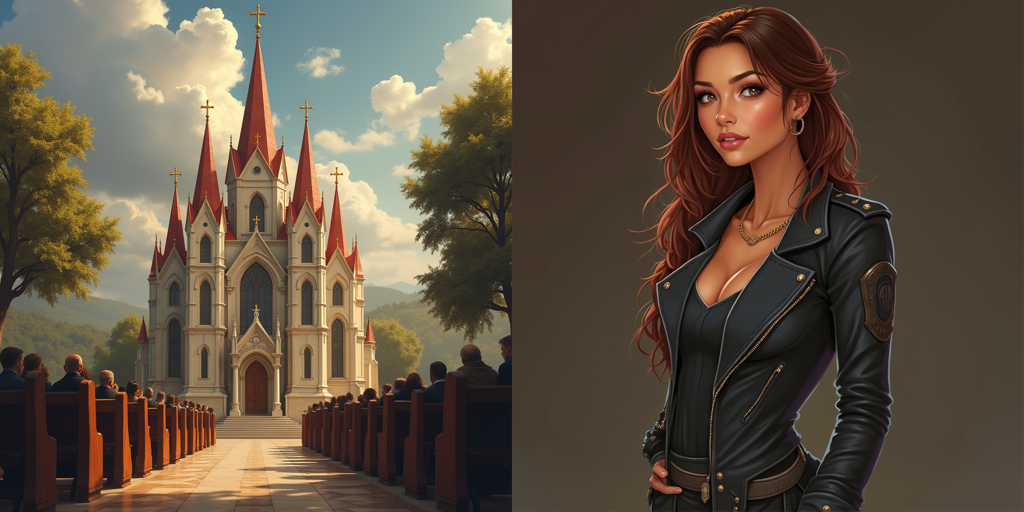

In [6]:
# Generate with original model
prompt = 'image of a church'
seed = random.randint(0, 2**15)


for key, ft_module in esd_weights.items():
    set_module(pipe.transformer, key, ft_module)

esd_image = pipe(prompt, 
             num_inference_steps = num_inference_steps,
             guidance_scale= guidance_scale,
             height=height,
             width=width,
             generator=torch.Generator().manual_seed(seed),
             max_sequence_length=max_sequence_length,
            ).images[0]

for key, ft_module in original_weights.items():
    set_module(pipe.transformer, key, ft_module)

original_image = pipe(prompt, 
                    num_inference_steps = num_inference_steps,
                    guidance_scale= guidance_scale,
                    height=height,
                    width=width,
                    generator=torch.Generator().manual_seed(seed),
                    max_sequence_length=max_sequence_length,
                    ).images[0]


make_image_grid([original_image, esd_image], rows=1, cols=2).resize((512*2, 512))
